# Multiple Objectives for Residential PV

## Set up.

### Import packages.

In [1]:
import os
import sys
sys.path.insert(0, os.path.abspath(".."))

In [2]:
import numpy             as np
import matplotlib.pyplot as pl
import pandas            as pd
import seaborn           as sb
import tyche             as ty

## Load data.

### The data are stored in a set of tab-separated value files in a folder.

In [3]:
designs = ty.Designs("../../data/residential_pv_multiobjective")

In [4]:
investments = ty.Investments("../../data/residential_pv_multiobjective")

### Compile the production and metric functions for each technology in the dataset.

In [5]:
designs.compile()

## Multi-objective decision analysis.

### Compute costs and metrics for tranches.

Tranches are atomic units for building investment portfolios. Evaluate all of the tranches, so we can assemble them into investments (portfolios).

In [6]:
tranche_results = investments.evaluate_tranches(designs, sample_count=50)

### Fit a response surface to the results.

The response surface interpolates between the discrete set of cases provided in the expert elicitation. This allows us to study funding levels intermediate between those scenarios.

In [7]:
evaluator = ty.Evaluator(investments.tranches, tranche_results.summary)

Here are the categories of investment and the maximum amount that could be invested in each:

In [8]:
evaluator.max_amount

,Amount
Category,
BoS R&D,900000.0
Inverter R&D,3000000.0
Module R&D,4500000.0


Here are the metrics and their units of measure:

In [9]:
evaluator.units

,Units
Index,
GHG,ΔgCO2e/system
LCOE,Δ$/kWh
Labor,Δ$/system


#### Example interpolation.

Let's evaluate the case where each category is invested in at half of its maximum amount.

In [10]:
example_investments = evaluator.max_amount / 2
example_investments

,Amount
Category,
BoS R&D,450000.0
Inverter R&D,1500000.0
Module R&D,2250000.0


In [11]:
evaluation = evaluator.evaluate(example_investments)
evaluation

Category    Index  Sample
BoS R&D     GHG    1         -0.0002360203370486147
                   2          -0.003871661313311847
                   3         -0.0027720893091469634
                   4          -0.007952017130165245
                   5          0.0006863363114462118
                                      ...          
Module R&D  Labor  46          0.047895644658751735
                   47         -0.010515314354051952
                   48          0.019312410680299763
                   49          -0.03632795744442774
                   50           0.03816636646035931
Name: Value, Length: 450, dtype: object

In [12]:
evaluator.units.loc["GHG"]

Units    ΔgCO2e/system
Name: GHG, dtype: object

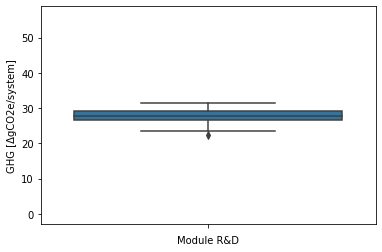

In [13]:
summary = evaluation.xs("GHG", level = "Index")
values = summary.xs("Module R&D", level = "Category")
plt = sb.boxplot(y = values)
y0 = min(0, evaluator.min_metric.loc["GHG"][0])
y1 = max(0, evaluator.max_metric.loc["GHG"][0])
dy = (y1 - y0) / 20
plt.set(
  xlabel = "Module R&D",
  ylabel = "GHG [" + evaluator.units.loc["GHG"].values[0] + "]",
  ylim = (y0 - dy, y1 + dy),
);

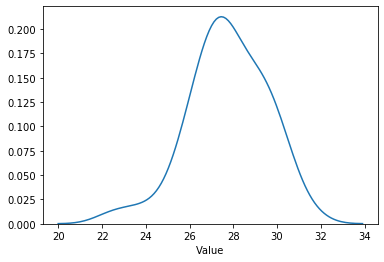

In [16]:
sb.distplot(values, hist = False)

Let's evaluate the mean instead of outputing the whole distribution.

In [14]:
evaluator.evaluate_statistic(example_investments, np.mean)

Index
GHG       30.058781
LCOE       0.038195
Labor   -248.278273
Name: Value, dtype: float64

Here is the standard deviation:

In [15]:
evaluator.evaluate_statistic(example_investments, np.std)

Index
GHG       1.567267
LCOE      0.000782
Labor    15.968446
Name: Value, dtype: float64

A risk-averse decision maker might be interested in the 10% percentile:

In [16]:
evaluator.evaluate_statistic(example_investments, lambda x: np.quantile(x, 0.1))

Index
GHG       28.069111
LCOE       0.037098
Labor   -270.612455
Name: Value, dtype: float64

### ε-Constraint multiobjective optimization

In [17]:
optimizer = ty.EpsilonConstraintOptimizer(evaluator)

In order to meaningfully map the decision space, we need to know the maximum values for each of the metrics.

In [18]:
metric_max = optimizer.max_metrics()
metric_max

GHG      49.313530
LCOE      0.062727
Labor     0.056313
Name: Value, dtype: float64

#### Example optimization.

Limit spending to $3M.

In [19]:
investment_max = 3e6

Require that the GHG reduction be at least 40 gCO2e/system and that the Labor wages not decrease.

In [20]:
metric_min = pd.Series([40, 0], name = "Value", index = ["GHG", "Labor"])
metric_min

GHG      40
Labor     0
Name: Value, dtype: int64

Compute the ε-constrained maximum for the LCOE.

In [21]:
optimum = optimizer.maximize(
    "LCOE"                       ,
    total_amount = investment_max,
    min_metric   = metric_min    ,
    statistic    = np.mean       ,
)
optimum.exit_message

'Optimization terminated successfully'

Here are the optimal spending levels:

In [22]:
np.round(optimum.amounts)

Category
BoS R&D               0.0
Inverter R&D          0.0
Module R&D      3000000.0
Name: Amount, dtype: float64

Here are the three metrics at that optimum:

In [23]:
optimum.metrics

Index
GHG      41.103373
LCOE      0.037285
Labor     0.019779
Name: Value, dtype: float64

*Thus, by putting all of the investment into Module R&D, we can expected to achieve a mean 3.75 ¢/kWh reduction in LCOE under the GHG and Labor constraints.*

It turns out that there is no solution for these constraints if we evaluate the 10th percentile of the metrics, for a risk-averse decision maker.

In [24]:
optimum = optimizer.maximize(
    "LCOE"                       ,
    total_amount = investment_max,
    min_metric   = metric_min    ,
    statistic    = lambda x: np.quantile(x, 0.1),
)
optimum.exit_message

'Positive directional derivative for linesearch'

Let's try again, but with a less stringent set of constraints, only constraining GHG somewhat but not Labor at all.

In [25]:
optimum = optimizer.maximize(
    "LCOE"                                                         ,
    total_amount = investment_max                                  ,
    min_metric   = pd.Series([30], name = "Value", index = ["GHG"]),
    statistic    = lambda x: np.quantile(x, 0.1)                   ,
)
optimum.exit_message

'Optimization terminated successfully'

In [26]:
np.round(optimum.amounts)

Category
BoS R&D               0.0
Inverter R&D          0.0
Module R&D      3000000.0
Name: Amount, dtype: float64

In [27]:
optimum.metrics

Index
GHG      36.856980
LCOE      0.035350
Labor    -0.026232
Name: Value, dtype: float64